In [ ]:
#default_exp core

# core

> Common, useful functions to use in several places.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pathlib import Path
import os
import geopandas as gpd
import pandas as pd
from osgeo import gdal
import shapely
from shapely.geometry import Point, Polygon, box, shape
import numpy as np
from itertools import product
from typing import Tuple
from tqdm import tqdm
import affine
import rasterio as rio
import matplotlib.pyplot as plt

## Utilities

In [ ]:
#export

def rangeof(iterable):
    "Equivalent for range(len(iterable))"
    return range(len(iterable))

## Grids and coordinate transformations

In [ ]:
#export

def make_grid(path, gridsize_x:int=640, gridsize_y:int=480, 
              overlap:Tuple[int, int]=(100,100)) -> gpd.GeoDataFrame:
    """Creates a grid template with `gridsize_x` times `gridsize_y` cells, with `overlap` pixels of overlap
    based on geotiff file in `path`. Returns a gpd.GeoDataFrame with `RyyCxx` identifier for each geometry 
    """
    ds = gdal.Open(path)
    ulx, xres, xskew, uly, yskew, yres = ds.GetGeoTransform()
    lrx = ulx + (ds.RasterXSize * xres)
    lry = uly + (ds.RasterYSize * yres)
    # number of output cells is calculated like conv output
    ncols = int(np.floor((np.floor((lrx - ulx) / xres)) - gridsize_x) / (gridsize_x - overlap[0]) + 1)
    nrows = int(np.floor((np.floor((lry - uly) / yres)) - gridsize_y) / (gridsize_y - overlap[1]) + 1)
    polys = []
    names = []
    for col, row in (product(range(ncols), range(nrows))):
        ytop = lry - row * (yres * (gridsize_y - overlap[1]))
        ybot = ytop - (yres * gridsize_y)
        xleft = ulx + col * (xres * (gridsize_x - overlap[0]))
        xright = xleft + (xres * gridsize_x)
        polys.append(Polygon([(xleft,ytop), (xright,ytop), (xright,ybot), (xleft,ybot)]))
        names.append(f'R{row}C{col}')
    grid = gpd.GeoDataFrame({'cell': names, 'geometry':polys})
    ds = None
    return grid

In [ ]:
# export

def convert_poly_coords(geom:shape, raster_src:str=None, affine_obj:affine.Affine=None,
                        inverse:bool=False, precision=None) -> shape:
    "Adapted from solaris. Converts georeferenced coordinates to pixel coordinates and vice versa"
    if not raster_src and not affine_obj:
        raise ValueError("Either raster_src or affine_obj must be provided.")

    if raster_src is not None:
        affine_xform = get_geo_transform(raster_src)
    else:
        if isinstance(affine_obj, affine.Affine):
            affine_xform = affine_obj
        else:
            # assume it's a list in either gdal or "standard" order
            # (list_to_affine checks which it is)
            if len(affine_obj) == 9:  # if it's straight from rasterio
                affine_obj = affine_obj[0:6]
            affine_xform = list_to_affine(affine_obj)

    if inverse:  # geo->px transform
        affine_xform = ~affine_xform

    if isinstance(geom, str):
        # get the polygon out of the wkt string
        g = shapely.wkt.loads(geom)
    elif isinstance(geom, shapely.geometry.base.BaseGeometry):
        g = geom
    else:
        raise TypeError('The provided geometry is not an accepted format. '
                        'This function can only accept WKT strings and '
                        'shapely geometries.')

    xformed_g = shapely.affinity.affine_transform(g, [affine_xform.a,
                                                      affine_xform.b,
                                                      affine_xform.d,
                                                      affine_xform.e,
                                                      affine_xform.xoff,
                                                      affine_xform.yoff])
    if isinstance(geom, str):
        # restore to wkt string format
        xformed_g = shapely.wkt.dumps(xformed_g)
    if precision is not None:
        xformed_g = _reduce_geom_precision(xformed_g, precision=precision)

    return xformed_g    

def affine_transform_gdf(gdf:gpd.GeoDataFrame, affine_obj:affine.Affine, inverse:bool=False, 
                         geom_col:str='geometry', precision:int=None) -> gpd.GeoDataFrame:
    """Adapted from solaris, transforms all geometries in GeoDataFrame to pixel coordinates from
    Georeferced coordinates and vice versa"""
    if 'geometry' not in gdf.columns: gdf = gdf.rename(columns={geom_col: 'geometry'})
    gdf["geometry"] = gdf["geometry"].apply(convert_poly_coords,
                                            affine_obj=affine_obj,
                                            inverse=inverse)
    if precision is not None:
        gdf['geometry'] = gdf['geometry'].apply(
            _reduce_geom_precision, precision=precision)

    # the CRS is no longer valid - remove it
    gdf.crs = None

    return gdf


def gdf_to_px(gdf:gpd.GeoDataFrame, im_path, geom_col:str='geometry', precision:int=None,
              outpath=None, override_crs=False) -> gpd.GeoDataFrame:
    "Adapted from https://solaris.readthedocs.io/en/latest/_modules/solaris/vector/polygon.html#geojson_to_px_gdf"
    
    with rio.open(im_path) as im:
        affine_obj = im.transform
    
    transformed_gdf = affine_transform_gdf(gdf, affine_obj=affine_obj,
                                           inverse=True, precision=precision,
                                           geom_col=geom_col)
    
    transformed_gdf['image_fname'] = os.path.split(im_path)[1]

    if outpath is not None:
        if outpath.lower().endswith('json'):
            transformed_gdf.to_file(outpath, driver='GeoJSON')
        else:
            transformed_gdf.to_csv(outpath, index=False)
    return transformed_gdf

def georegister_px_df(df:pd.DataFrame, im_path=None, affine_obj:affine.Affine=None, crs=None,
                      geom_col:str='geometry', precision:int=None, output_path=None) -> gpd.GeoDataFrame:
    with rio.open(im_path) as im:
        affine_obj = im.transform
        crs = im.crs
    
    tmp_df = affine_transform_gdf(df, affine_obj, geom_col=geom_col,
                                  precision=precision)
    result = gpd.GeoDataFrame(tmp_df, crs='epsg:' + str(crs.to_epsg()))

    if output_path is not None:
        if output_path.lower().endswith('json'):
            result.to_file(output_path, driver='GeoJSON')
        else:
            result.to_csv(output_path, index=False)

    return result


In [ ]:
gdf = gpd.read_file('data/R70C21.shp')
im_path = 'data/R70C21.tif'

In [ ]:
with rio.open(im_path) as im: im_data = im.read()

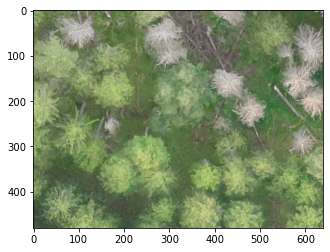

In [ ]:
plt.imshow(im_data.swapaxes(0,2).swapaxes(0,1))

<AxesSubplot:>

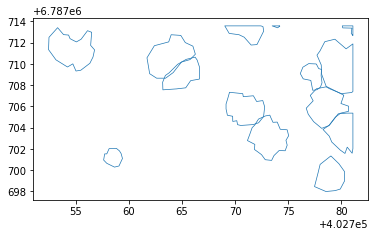

In [ ]:
gdf.plot(column='label', facecolor='none', edgecolor='black', lw=0.7)

In [ ]:
tfmd_gdf = gdf_to_px(gdf, im_path)

<AxesSubplot:>

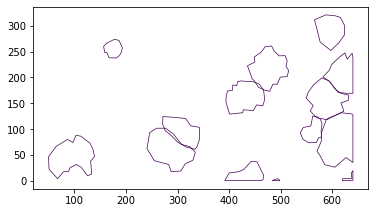

In [ ]:
tfmd_gdf.plot(column='label', facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')

Origin is located here in lower-left when typically its located in upper-right.

<AxesSubplot:>

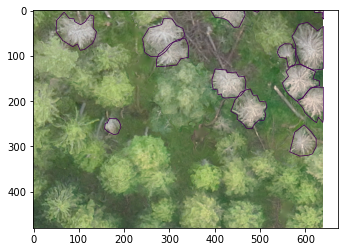

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im_data.swapaxes(0,2).swapaxes(0,1))
tfmd_gdf.plot(ax=ax, column='label', facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')

But overlaid on image it's correct for our purposes.

In [ ]:
tfmd_gdf = georegister_px_df(tfmd_gdf, im_path)

<AxesSubplot:>

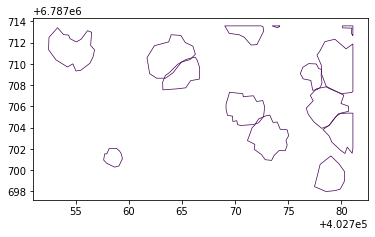

In [ ]:
tfmd_gdf.plot(column='label', facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')

## Non-max suppression for shapefile bounding boxes

In [ ]:
# export
 
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlap_thresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes    
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))
 
    # return indices for selected bounding boxes
    return pick
    #return boxes[pick].astype("int")

In [ ]:
boxes = [b for b in gdf.geometry]
boxes_np = [b.bounds for b in boxes]

In [ ]:
pick = non_max_suppression_fast(np.array(boxes_np), 0.4)

In [ ]:
selected_bboxes = tfmd_gdf.iloc[pick].copy()

<AxesSubplot:>

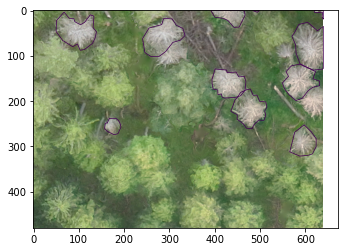

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im_data.swapaxes(0,2).swapaxes(0,1))
gdf_to_px(selected_bboxes, im_path).plot(column='label', ax=ax, facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')

## Math formulae (for fallen deadwood volume estimation)

In [ ]:
# export

def cone_v(r:float, h:float) -> float:
    "V = (Ah)/3"
    A = np.pi * r**2
    V = (A * h) / 3
    return V

def cut_cone_v(r_1:float, r_2:float, h:float):
    "V = (h(A + sqrt(A*A') + A))/3"
    A_1 = np.pi * r_1**2
    A_2 = np.pi * r_2**2
    V = (h*(A_1 + np.sqrt(A_1 * A_2) + A_2))/3
    return V


In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_core.ipynb.
Converted 01_preprocessing.ipynb.
Converted 02_detectors.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/drone_detector/nbs/00_core.ipynb
converting: /mnt/d/Users/E1005164/drone_detector/nbs/01_preprocessing.ipynb
